# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: spherical harmonics vs graph Fourier modes

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
import pygsp as pg
import itertools

from deepsphere import utils

In [4]:
plt.rcParams['figure.figsize'] = (17, 5)  # (9, 4) for matplotlib notebook

nside = 16
cm = plt.cm.RdBu_r
cm.set_under('w')

## 4 Correspondance of the subspaces

* Are the subspaces equivalent?
* Is the projection on the subspaces similar?
* TODO: what is `win = hp.sphtfunc.pixwin(nside=32)`?

### 4.2 The sampled spherical harmonics don't form an orthonormal basis

* The spherical harmonics are not exactly orthonormal (they don't form a basis).
* They're not orthonormal as they are a sampling of the true eigenfunctions.
* If the sampling is not uniform, the dot product is not equal to the integral.

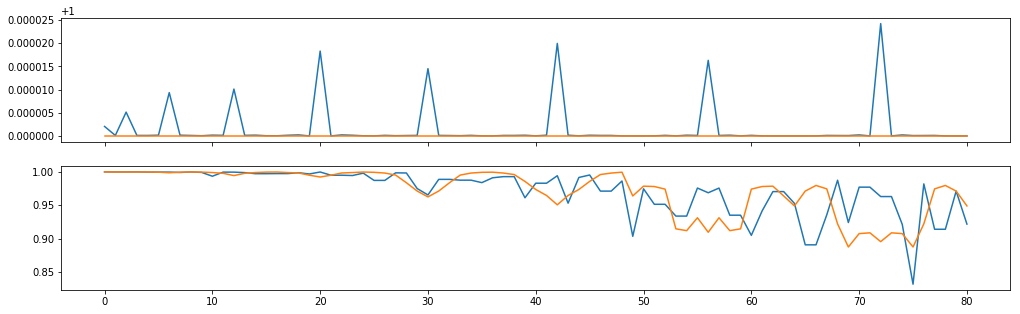

In [7]:
def show_non_orthogonality(nside, lmax):

    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics[-1])

    C = harmonics.T @ harmonics
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(np.sum(C**2, axis=1))
    axes[0].plot(C.diagonal())

    # Hence the rows and columns of the correlation matrix don't sum up to one.
    C = harmonics.T @ graph.U[:, :harmonics.shape[1]]
    axes[1].plot(np.sum(C**2, axis=0))
    axes[1].plot(np.sum(C**2, axis=1));

show_non_orthogonality(nside=16, lmax=8)

### 4.3 Percentage of energy in the corresponding subspaces

TODO: the graph should be constructed (if that's even possible) such that the Fourier modes converge to the spherical harmonics while we sample more (i.e., nside increases).

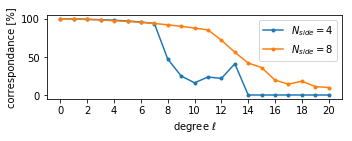

In [8]:
lmax = 20
nsides = [4, 8]

# Normalized corresponds better than combinatorial. Less difference between nsides.
# lap_type='combinatorial'
lap_type='normalized'

def compute_orhtogonality(nside, lmax, lap_type='normalized'):
    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))

    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)

    graph = utils.healpix_graph(nside, lap_type=lap_type, nest=True, dtype=np.float64)
    n_eigenvectors = min(n_harmonics[-1], graph.N)
    graph.compute_fourier_basis(n_eigenvectors)

    C = harmonics.T @ graph.U
    
    return C, n_harmonics

def compute_energy(C, lmax):
    """Compute the percentage energy in each subspace (diagonal blocks)."""
    energy_in = np.empty(lmax+1)
    start = 0
    for ell in range(lmax + 1):
        n_harmonics = 2*ell + 1
        end = start + n_harmonics
        energy_square = np.sum(C[start:end, start:end]**2)
        # col_sum = np.sum(C[start:end, :]**2)  # how each harmonic are distributed on all eigenvectors
        # row_sum = np.sum(C[:, start:end]**2)  # how each eigenvector are distributed on all harmonics
        # np.testing.assert_allclose(col_sum, n_harmonics, rtol=1e-2)
        # np.testing.assert_allclose(row_sum, n_harmonics, rtol=1e-2)
        energy_in[ell] = energy_square / n_harmonics
        start = end
    return energy_in

energy = dict()

for nside in nsides:
    C, _ = compute_orhtogonality(nside, lmax, lap_type)
    energy[nside] = compute_energy(C, lmax)

fig, ax = plt.subplots(figsize=(5, 2))
for nside in nsides:
    ax.plot(range(lmax+1), 100*energy[nside], '.-', label=rf'$N_{{side}}={nside}$')
ax.legend()
ax.set_ylabel('correspondance [%]')
ax.set_xlabel('degree $\ell$')
ax.set_xticks(range(0, lmax + 1, lmax//10))
fig.tight_layout();
# fig.savefig(os.path.join(pathfig, 'subspace_alignment.pdf'))

### 4.4 approximate SHT with a NUDFT (anafast) of the graph eigenvectors

That is a better way to compare, as it uses the real spherical harmonic transform (SHT).

### ANAFAST: what is it?
Execution of anafast requires a user to specify the maximum spherical harmonic order  $\ell_{\mathrm{max}}$ up to which the harmonic decomposition of the input maps will be performed. Since there are no formal limits on parameter  $\ell_{\mathrm{max}}$ enforced by anafast, the user should make his/her choices judiciously. Hereafter it is convenient to specify  $\ell_{\mathrm{max}}$ in terms of the HEALPix map resolution parameter Nside (called nsmax in some other contexts). 

If the function to be analysed is strictly band-width limited, or nearly band-width limited (as in the case of a Gaussian beam smoothed signal discretized at a rate of a few pixels per beam area), it is sufficient to run anafast with  $\ell_{\mathrm{max}}\approx 2\cdot N_{\mathrm{side}}$, with a very good $C_\ell$ error performance already in the raw (i.e. uncorrected quadrature) harmonic transform mode. If quadrature corrections are still desired in this case, it should be sufficient to use, at no extra cost in execution time, the ring-weighted quadrature scheme. This is the recommended mode of operation of anafast for essentially error and worry free typical applications, e.g. CPU-intensive Monte Carlo studies. 

A new set of pixel-based quadrature weights was introduced in HEALPix 3.40. Pre-computed to inforce a (near) ideal integration of the spherical harmonics $Y_{\ell m}$ on the pixelized sphere (ie  $\frac{4\pi}{N_{\mathrm{pix}}} \sum_p w(p) Y_{\ell m}(p) = \sqrt{4 \pi} \delta_{\ell 0}\delta_{m 0}$) for  $\vert m\vert \le \ell \le 3 N_{\mathrm{side}}$, they can be used to insure that the $a_{\ell m}$ and $C_\ell$ computed by anafast are perfectly accurate (almost to machine precision) without the need for iterations, but only for band-width limited input signal with  $\ell_{\mathrm{max}}\le 1.5 N_{\mathrm{side}}$. 

If more aggressive attempts are undertaken to extract from a map the spectral coefficients at  $\ell > 2\cdot N_{\mathrm{side}}$ (for example, as in a possible case of an attempt to analyse an existing map, which was irreversibly binned at a suboptimal resolution) the following should be kept in mind: 

$\bullet$ __Spherical harmonics discretized using HEALPix (either sampled at pixel centers, or avaraged over pixel areas) form a linearly independent system up to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$. Hence, the functions which are strictly band-width limited to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$ can be fully spectrally resolved with anafast, albeit with integration errors in the uncorrected quadrature mode__, which grow up to  $\delta C_\ell \propto \epsilon \cdot C_\ell$, with $\epsilon <0.1$, at the highest values of $\ell$. These integration errors can be efficiently reduced using anafast in the iterative mode. Although this  $\ell_{\mathrm{max}}$ range --  $2 \cdot N_{\mathrm{side}}< \ell_{\mathrm{max}}< 3 \cdot N_{\mathrm{side}}- 1$ -- is easily manageable with anafast used on strictly band-width limited functions, it should be used with caution in basic and automated applications, e.g. Monte Carlo simulations. 

$\bullet$ __As with any discrete Fourier transform, anafast application to functions which are not band-width limited results with aliasing of power, which can not be remedied__. If the particular case of interest may result in such a band-width violation (i.e. there is significant power in the function at  $\ell > 3 \cdot N_{\mathrm{side}}-1$), the function should be smoothed before the application of anafast, or discretized and then analysed, on a refined HEALPix grid (with larger Nside). 

$\bullet$ REMEMBER: A peculiar property of the sphere, which usually surprises those whose intuition is built on experience with FFTs on a segment, or on a Euclidean
multidimensional domain, is the lack of a regular and uniform point-set at arbitrary resolution, and the resulting __non-commutativity of the forward and backward discrete Fourier transforms__ on nearly-uniform point-sets, e.g. HEALPix. Hence, as in any case of attempting an extreme application of an off-the-shelf software, use caution and understand your problem well before executing anafast under such circumstances!


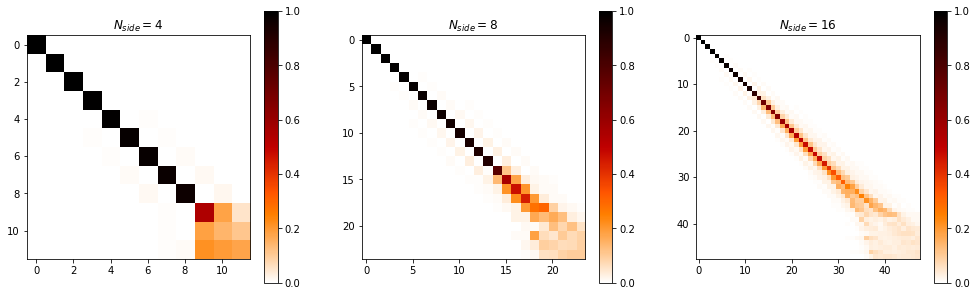

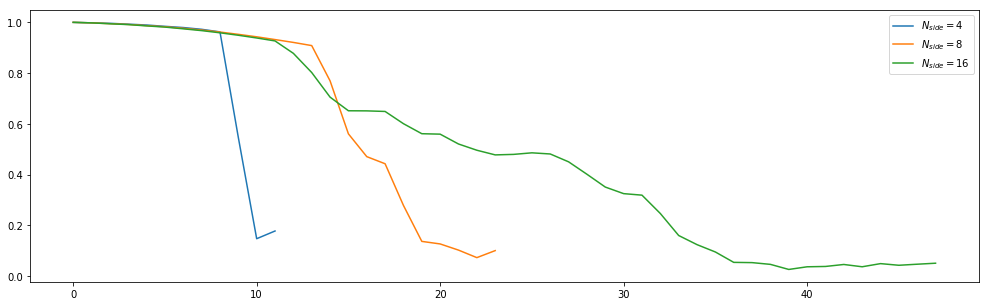

In [10]:
# nsides = [4, 8, 16, 32]  # slow
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1  # default in healpy.anafast

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64, std_dev='kernel_width')
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

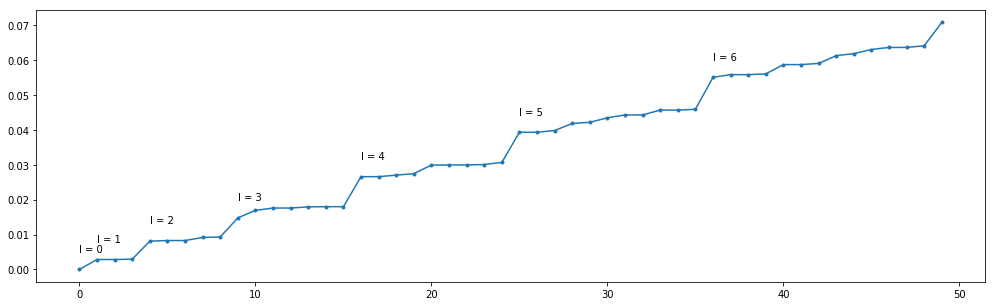

In [11]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### 4.5 Testing convergence of Belkin & Nyiogi setting
More or less: here the sampling is deterministic (HEALPix) but we construct a full graph

I added two functions to deepsphere.utils: __full_healpix_graph__ and __full_healpix_weightmatrix__.
__full_healpix_weightmatrix__() uses as standard deviation of the gaussin kernel exactly the formula used in Belkin&Nyiogi, and NOT the mean of the distances.

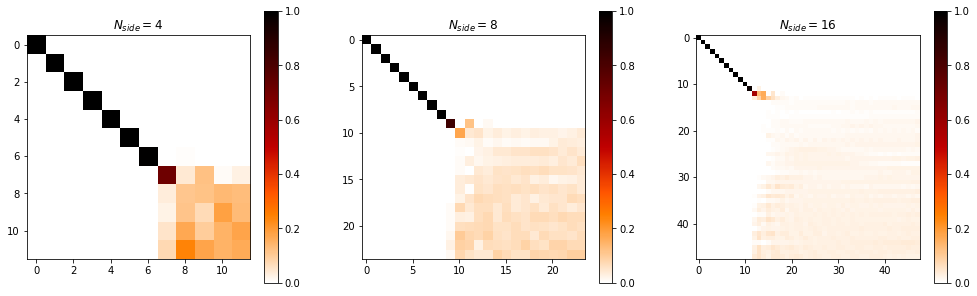

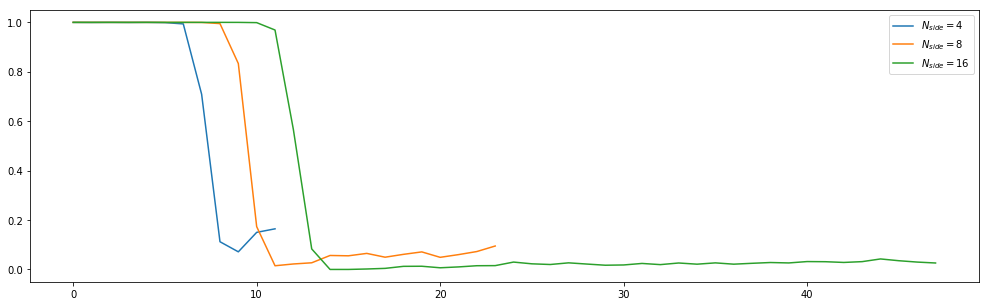

In [4]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std="BelkinNyiogi")  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

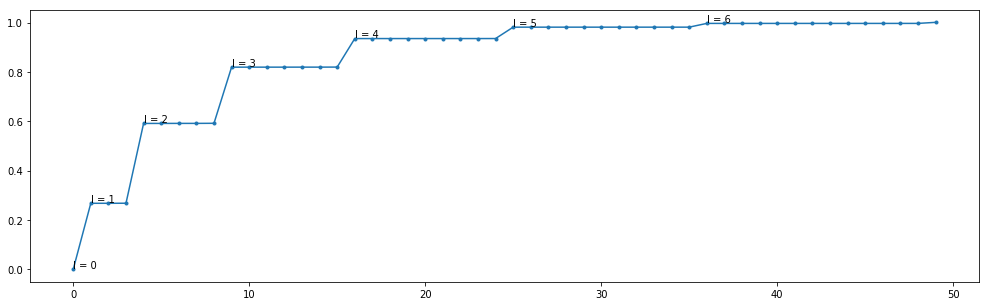

In [61]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

Nath's thought: 

### 4.6 Now we try with a FULL graph with a standard deviation set to mean distance of the dataset
This is to see if the convergence is due to the standard deviation or to the density pattern (or both)

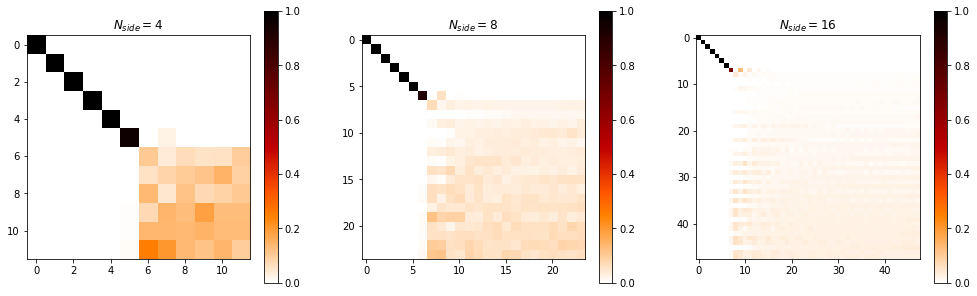

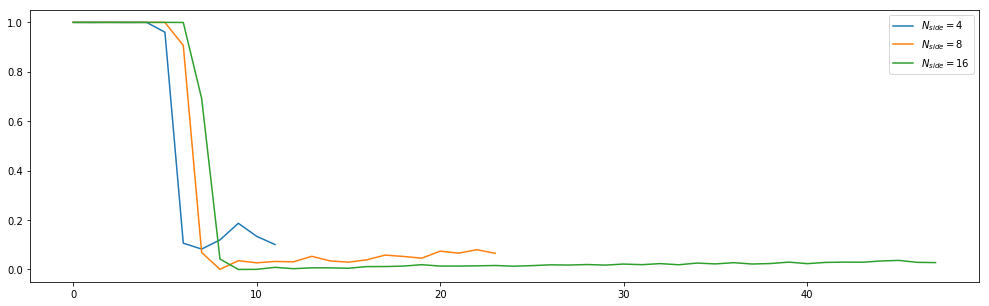

In [62]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std="kernel_width")  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

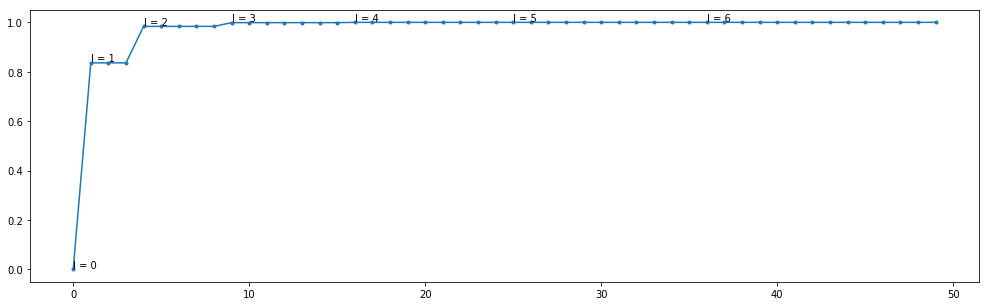

In [63]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

It seems that the convergence is still there, but now it is way slower! Now the question is: what is provoking this convergence? a Shannon theorem (perfect reconstruction up to a certain bandwidth) or is it just an asymptotic thing (Belking/Nyiogi style)? The superfast decay of the plot indicating the energy on the diagonal indicate that the graph fourier eigenvectors approximate the real sphericl harmonics almost exactly for a while, and then boom something wrong happens.

Now that we saw that the std dev is really important, let's see what happens to the sparse graph (7/8 neighbors) and the Belkin & Nyiogi std. dev.!

### 4.7 Sparse graph with Belkin-Nyiogi standard deviation

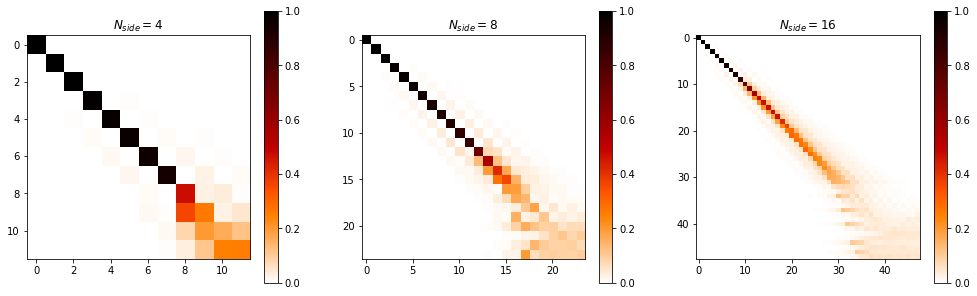

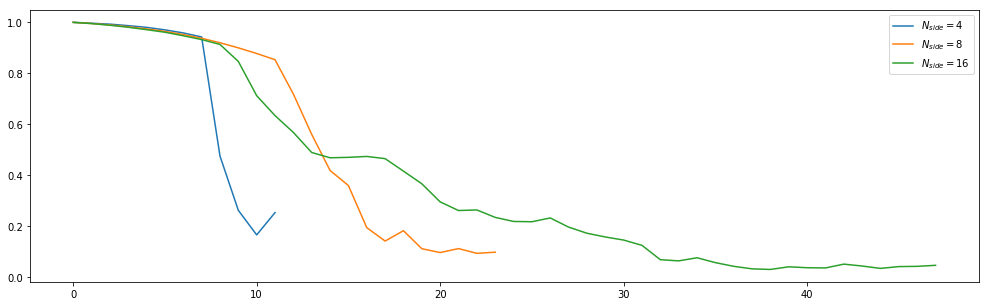

In [64]:
# nsides = [4, 8, 16, 32]  # slow
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64, std_dev='BelkinNyiogi')
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

__In this case (sparse graph) the standard deviation does not seem to help at all!__

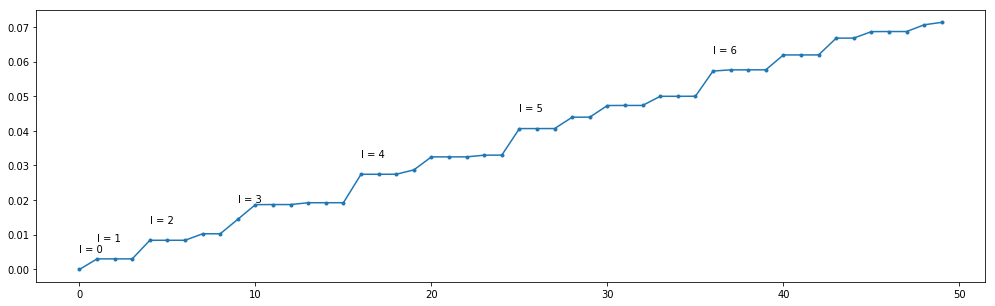

In [65]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### 4.7 Just for confirmation: SHT of the sampled spherical harmonics

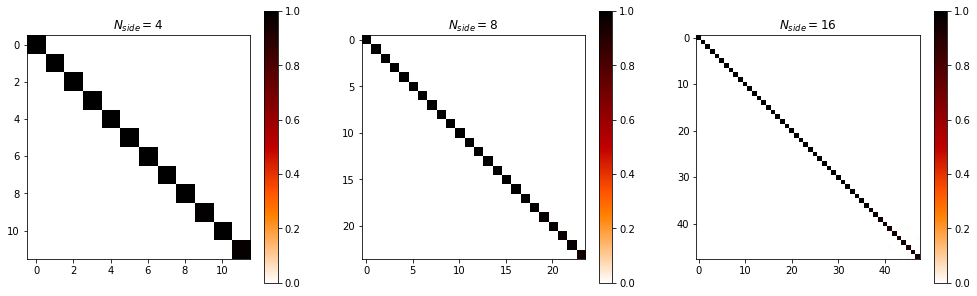

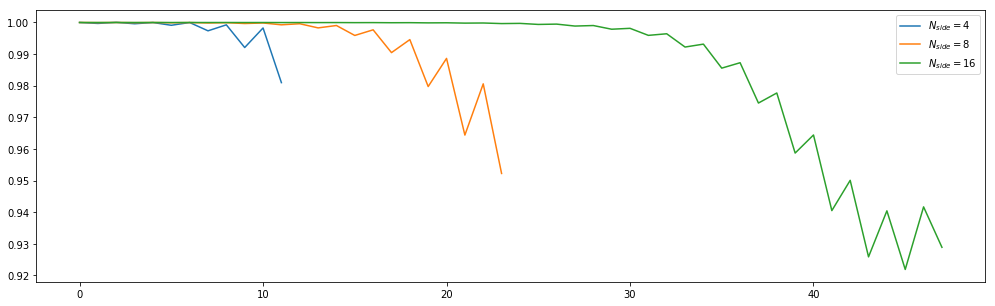

In [30]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1
    
    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
    n_harmonics = harmonics.shape[1]
    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        harmonic = hp.reorder(harmonics[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(harmonic, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();


## 5 Analysis of the sparsity of the graph

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


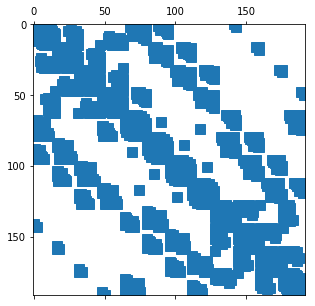

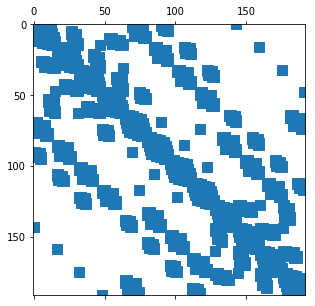

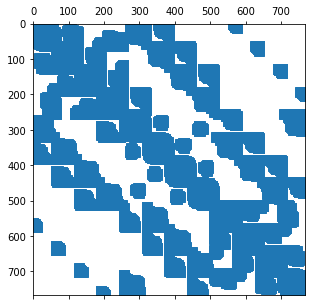

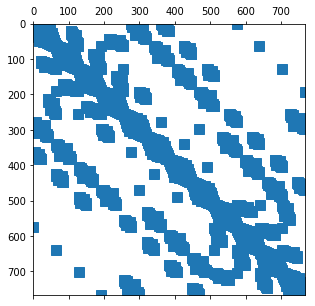

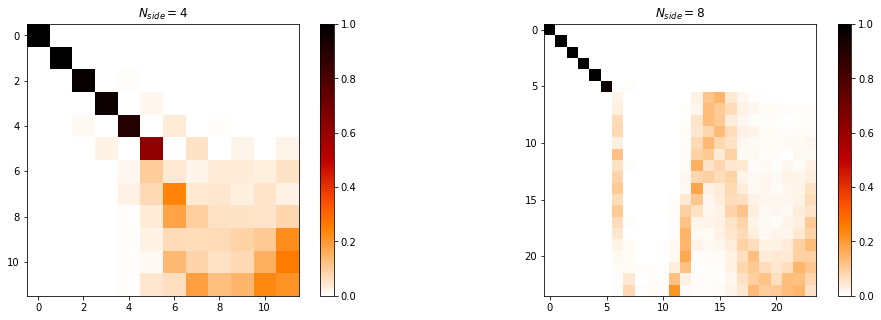

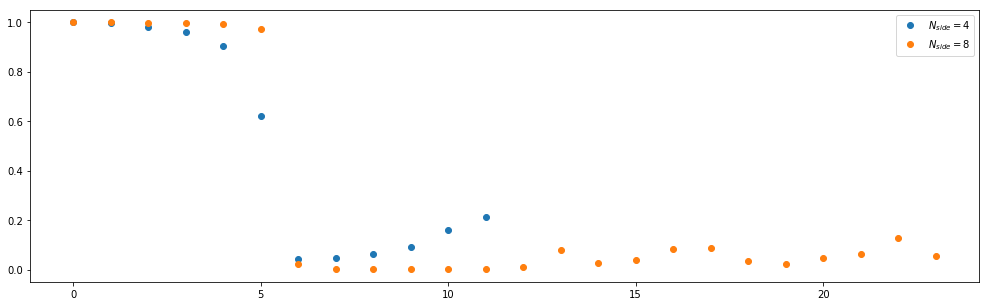

In [58]:
nsides = [4, 8]

spectral_content = dict()


ks=[0.9252874820330129]
for k in ks:
    for nside in nsides:

        lmax = 3 * nside - 1

        n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
        
        graph = utils.full_healpix_graph(nside, dtype=np.float64, std="kernel_width")  # in NEST order
        # graph = utils.healpix_graph(nside, dtype=np.float64)  # in NEST order
        
        # thresholding weights to impose sparsity 
        
        W = graph.W.copy()
        W[W < k] = 0
        plt.spy(W)
        plt.show()
        plt.spy(utils.healpix_graph(nside, dtype=np.float64).W)
        plt.show()
        graph = pg.graphs.Graph(W)
       
        graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

        cl = np.empty((n_harmonics, lmax+1))
        for i in range(n_harmonics):
            eigenvector = hp.reorder(graph.U[:, i], n2r=True)
            # alm = hp.sphtfunc.map2alm(eigenvector)
            cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

        spectral_content[nside] = np.empty((lmax+1, lmax+1))
        start = 0
        for ell in range(lmax+1):
            end = start + (2 * ell + 1)
            spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
            start = end

    fig1, axes = plt.subplots(1, len(nsides))
    fig2, ax2 = plt.subplots()

    for ax, (nside, sc) in zip(axes, spectral_content.items()):
        sc = sc / sc[0, 0]
        im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
        fig1.colorbar(im, ax=ax)
        ax.set_title(rf'$N_{{side}}={nside}$')

        energy_in = np.diag(sc)
        ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

    ax2.legend();
    plt.show()

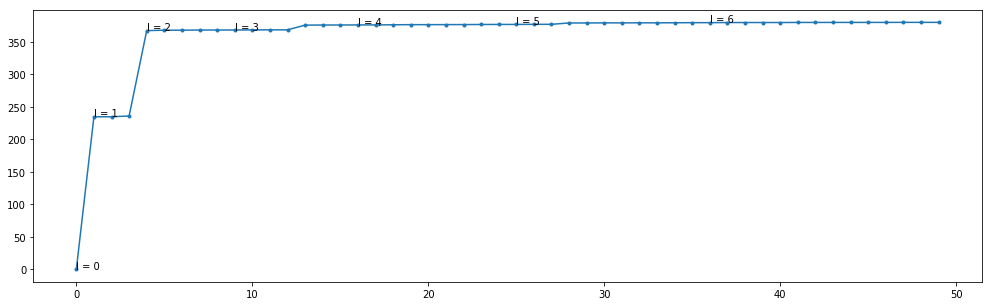

In [28]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1